In [ ]:
!git clone https://github.com/cardiffnlp/xlm-t

Cloning into 'xlm-t'...
remote: Enumerating objects: 212, done.
remote: Counting objects: 100% (77/77), done.
remote: Compressing objects: 100% (34/34), done.
remote: Total 212 (delta 71), reused 43 (delta 43), pack-reused 135 (from 1)
Receiving objects: 100% (212/212), 6.46 MiB | 18.28 MiB/s, done.
Resolving deltas: 100% (120/120), done.


In [ ]:
import os
import pandas as pd

def process_language(language):
    base_dir = "/content/xlm-t/data/sentiment"
    lang_path = os.path.join(base_dir, language)

    split = "test"
    all_rows = []

    with open(os.path.join(lang_path, f"{split}_text.txt"), encoding="utf-8") as text_file, \
        open(os.path.join(lang_path, f"{split}_labels.txt"), encoding="utf-8") as label_file:
        texts = text_file.read().splitlines()
        labels = label_file.read().splitlines()

    for text, label in zip(texts, labels):
        all_rows.append({
            "original_text": text,
            "label": label
        })

    df = pd.DataFrame(all_rows)
    df.to_csv(os.path.join(base_dir, f"{language}.csv"), index=False, encoding="utf-8")

In [ ]:
process_language("hindi")
process_language("arabic")
process_language("french")
process_language("german")
process_language("italian")
process_language("portuguese")
process_language("spanish")

In [ ]:
from transformers import AutoModelForSequenceClassification
from transformers import AutoTokenizer, AutoConfig
import numpy as np
from scipy.special import softmax
import torch

# Preprocess text (username and link placeholders)
def preprocess(text):
    new_text = []
    for t in text.split(" "):
        t = '@user' if t.startswith('@') and len(t) > 1 else t
        t = 'http' if t.startswith('http') else t
        new_text.append(t)
    return " ".join(new_text)

MODEL = f"cardiffnlp/twitter-xlm-roberta-base-sentiment"

tokenizer = AutoTokenizer.from_pretrained(MODEL)
config = AutoConfig.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)

def analyze_sentiment(text):
    text = preprocess(text)
    encoded_input = tokenizer(text, return_tensors='pt', truncation=True)
    with torch.no_grad():
        output = model(**encoded_input)
    scores = output[0][0].detach().numpy()
    scores = softmax(scores)
    labels = ['0', '1', '2'] # Negative; Neutral; Positive
    predicted_label = labels[np.argmax(scores)]
    return predicted_label, scores.tolist()


# perform sentiment analysis for each dataset
csv_dir = "/content/xlm-t/data/sentiment"
output_dir = os.path.join(csv_dir, "processed")
os.makedirs(output_dir, exist_ok=True)

for filename in os.listdir(csv_dir):
    if filename.endswith(".csv"):
        input_path = os.path.join(csv_dir, filename)
        df = pd.read_csv(input_path)

        predicted_labels = []
        confidence_scores = []

        for text in df["original_text"]:
            label, raw_scores = analyze_sentiment(str(text))
            predicted_labels.append(label)
            rounded_scores = [round(score, 2) for score in raw_scores]
            confidence_scores.append(rounded_scores)

        df["predicted_label"] = predicted_labels
        df["confidence_negative"] = [s[0] for s in confidence_scores]
        df["confidence_neutral"] = [s[1] for s in confidence_scores]
        df["confidence_positive"] = [s[2] for s in confidence_scores]

        output_path = os.path.join(output_dir, filename.replace(".csv", "_with_predictions.csv"))
        df.to_csv(output_path, index=False, encoding="utf-8")
        print(f"Processed and saved: {output_path}")

In [ ]:
import os
import pandas as pd

input_dir = "/content/xlm-t/data/sentiment/processed"

results = []

for file in os.listdir(input_dir):
    if file.endswith("_with_predictions.csv"):
        language = file.split("_")[0]

        df = pd.read_csv(os.path.join(input_dir, file))

        if "label" in df.columns and "predicted_label" in df.columns:
            correct = (df["label"].astype(str).str.lower() == df["predicted_label"].astype(str).str.lower()).sum()
            total = len(df)
            accuracy = round(correct / total, 3) if total > 0 else 0.0
            results.append({
                "language": language,
                "total": total,
                "correct": correct,
                "accuracy": accuracy
            })

accuracy_df = pd.DataFrame(results)
accuracy_df = accuracy_df.sort_values(by="accuracy", ascending=False)

print(accuracy_df)

     language  total  correct  accuracy
6  portuguese    870      664     0.763
3      german    870      654     0.752
0      french    870      643     0.739
4     spanish    870      606     0.697
5     italian    870      602     0.692
1      arabic    870      583     0.670
2       hindi    870      500     0.575


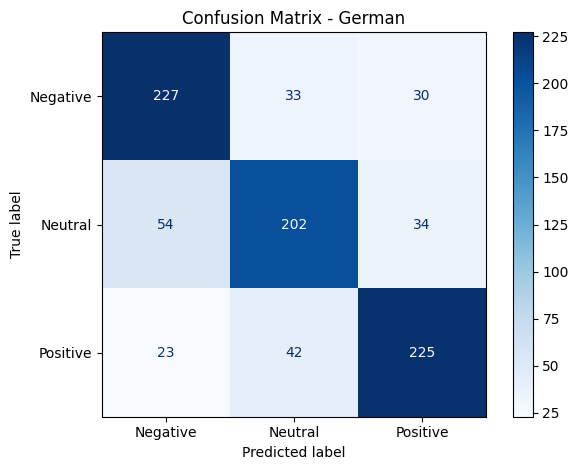

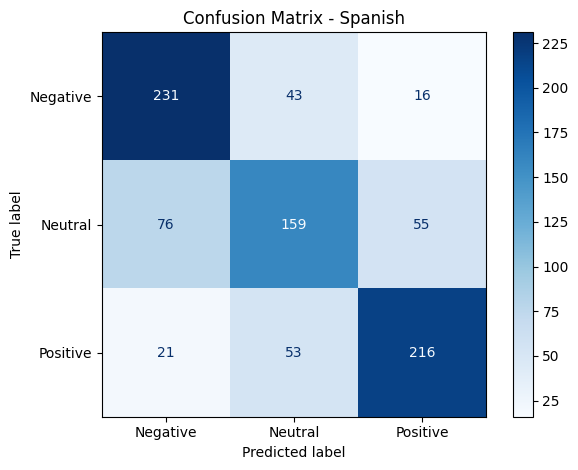

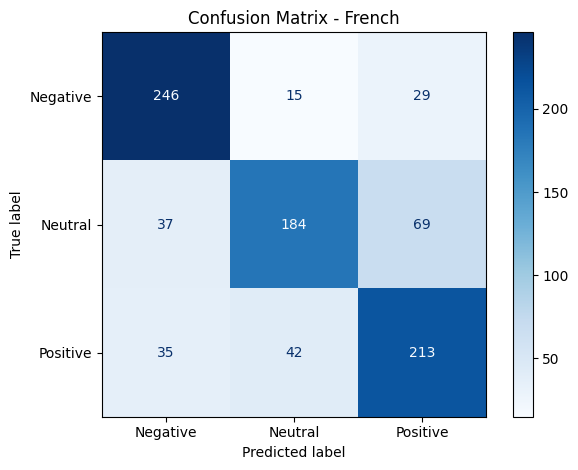

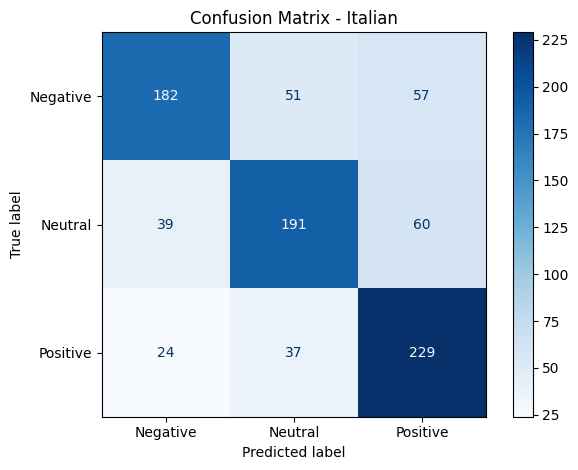


Per-language Accuracy:
     language  total  correct  accuracy
3  portuguese    870      664     0.763
1      german    870      654     0.752
5      french    870      643     0.739
2     spanish    870      606     0.697
6     italian    870      602     0.692
4      arabic    870      583     0.670
0       hindi    870      500     0.575


In [ ]:
import os
import pandas as pd
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

input_dir = "/content/xlm-t/data/sentiment/processed"
results = []

labels = ['0', '1', '2']  # 0 = Negative, 1 = Neutral, 2 = Positive
label_names = {'0': 'Negative', '1': 'Neutral', '2': 'Positive'}

target_languages = ['spanish', 'french', 'italian', 'german']

for file in os.listdir(input_dir):
    if file.endswith("_with_predictions.csv"):
        language = file.split("_")[0]

        df = pd.read_csv(os.path.join(input_dir, file))

        if "label" in df.columns and "predicted_label" in df.columns:
            # Normalize labels to strings
            df["label"] = df["label"].astype(str).str.strip()
            df["predicted_label"] = df["predicted_label"].astype(str).str.strip()

            correct = (df["label"] == df["predicted_label"]).sum()
            total = len(df)
            accuracy = round(correct / total, 3) if total > 0 else 0.0
            results.append({
                "language": language,
                "total": total,
                "correct": correct,
                "accuracy": accuracy
            })

            # Plot confusion matrix for target languages
            if language in target_languages:
                cm = confusion_matrix(df["label"], df["predicted_label"], labels=labels)
                disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[label_names[l] for l in labels])
                disp.plot(cmap="Blues", values_format='d')
                plt.title(f"Confusion Matrix - {language.capitalize()}")
                plt.tight_layout()
                plt.show()

accuracy_df = pd.DataFrame(results)
accuracy_df = accuracy_df.sort_values(by="accuracy", ascending=False)

print("\nPer-language Accuracy:")
print(accuracy_df)